# Chapter 1: Introduction

This project aims to perform flood detection using Sentinel-1 satellite imagery and the Google Earth Engine platform. By comparing radar images from pre- and post-flood periods, we can identify flooded areas and visualize water extent changes over time.

- Set up the environment and initialize Google Earth Engine.
- Define the Area of Interest (AOI) and fetch satellite images.
- Process and visualize the data to detect changes in water-covered areas.


# Chapter 2: Setting Up the Environment

In this phase, we import necessary libraries and authenticate access to Google Earth Engine.

In [1]:
import ee
import geemap
import os
import requests
import rasterio
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd




# Initialize the Earth Engine API 
ee.Authenticate()
ee.Initialize(project='atu-fyp')

# Chapter 3: Choosing the area and time range

Defining the Area of Interest (AOI)


According to The Irish Times: https://www.irishtimes.com/ireland/2023/10/19/cork-flooding-floods-in-co-cork-absolutely-devastating-as-safety-warning-issued-to-motorists/

We define the AOI for Cork, Ireland, which was heavily affected by floods in 2023. This AOI will be used to fetch and analyze satellite images.

Importing Libraries & Starting Earth Engine
In this phase, we import necessary libraries and initialize Google Earth Engine to fetch and process satellite images for a specific area and time range.

In [ ]:
# Define AOI for Cork City, Ireland
# Define coordinates using lat/lon
def create_aoi(lat_north, lat_south, lon_west, lon_east, buffer_size=1000):
    #Creates an AOI polygon with a buffer
    return ee.Geometry.Polygon([
        [
            [lon_west, lat_north],
            [lon_west, lat_south],
            [lon_east, lat_south],
            [lon_east, lat_north]
        ]
    ]).buffer(buffer_size) # aplying buffer

# Example usage
aoi = create_aoi(51.95, 51.80, -8.60, -8.15)

# Initialize the map
Map = geemap.Map(center=[51.8691, -8.2646], zoom=10)
Map.addLayer(aoi, {'color': 'brown'}, 'Area of Interest')
Map

Map(center=[51.8691, -8.2646], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# Chapter 4: Data collection Loading and Visualization

## 4.1 Loading Sentinel-1 Data
This section loads and filters Sentinel-1 satellite radar data for the specified flood event timeframes.  
It prepares the data for analysis by applying filters such as date, area, and polarization.

In [3]:
# Defines date ranges for pre-flood and post-flood periods
def define_date_ranges(pre_start, pre_end, post_start, post_end):
    return {
        'pre_flood_start': pre_start,
        'pre_flood_end': pre_end,
        'post_flood_start': post_start,
        'post_flood_end': post_end
    }

# usage
date_ranges = define_date_ranges('2023-09-01', '2023-09-30', '2023-10-01', '2023-10-31')
pre_flood_start = date_ranges['pre_flood_start']
pre_flood_end = date_ranges['pre_flood_end']
post_flood_start = date_ranges['post_flood_start']
post_flood_end = date_ranges['post_flood_end']

# Load Sentinel-1 GRD data for pre-flood period
pre_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(pre_flood_start, pre_flood_end) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV')

# Load Sentinel-1 GRD data for post-flood period
post_flood_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start, post_flood_end) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .select('VV')

# Get the median image for each period
pre_flood_image = pre_flood_collection.median()
post_flood_image = post_flood_collection.median()


# Add pre-flood and post-flood images to the map
Map.addLayer(pre_flood_image.clip(aoi), {'min': -20, 'max': 0}, 'Pre-Flood VV')
Map.addLayer(post_flood_image.clip(aoi), {'min': -20, 'max': 0}, 'Post-Flood VV')
Map.centerObject(aoi)
Map

Map(bottom=87045.0, center=[51.8691, -8.2646], controls=(WidgetControl(options=['position', 'transparent_bg'],…

In [4]:
# Define the export folder and filenames
export_folder = r'C:\Users\Neo\Desktop\FYP\Flood-Detection-System-FYP\Gee\images\flood_images'
pre_flood_filename = 'Pre_Flood_VV.png'
post_flood_filename = 'Post_Flood_VV.png'

# Ensure the export folder exists
os.makedirs(export_folder, exist_ok=True)

# Function to download an image as a PNG
def download_image_as_png(image, filename, vis_params=None):
    try:
        # Generate the thumbnail URL
        url = image.getThumbURL({
            'dimensions': 1024,  # Set the dimensions of the PNG
            'region': aoi.getInfo()['coordinates'],  # Export region
            'format': 'png',  # Save as PNG
            'min': -20,  # Minimum value for visualization
            'max': 0,  # Maximum value for visualization
            'palette': ['black', 'white']  # Grayscale palette
        })
        # Download the image
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            filepath = os.path.join(export_folder, filename)
            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
            print(f"Saved: {filepath}")
        else:
            print(f"Failed to download {filename}. HTTP Status Code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

# Download Pre-Flood VV image as PNG
download_image_as_png(pre_flood_image, pre_flood_filename)

# Download Post-Flood VV image as PNG
download_image_as_png(post_flood_image, post_flood_filename)

Saved: C:\Users\Neo\Desktop\FYP\Flood-Detection-System-FYP\Gee\images\flood_images\Pre_Flood_VV.png
Saved: C:\Users\Neo\Desktop\FYP\Flood-Detection-System-FYP\Gee\images\flood_images\Post_Flood_VV.png


Explanation

This section loads Sentinel-1 GRD data for pre-flood and post-flood periods and visualizes the median images.

## 4.1 Water area analysis over time


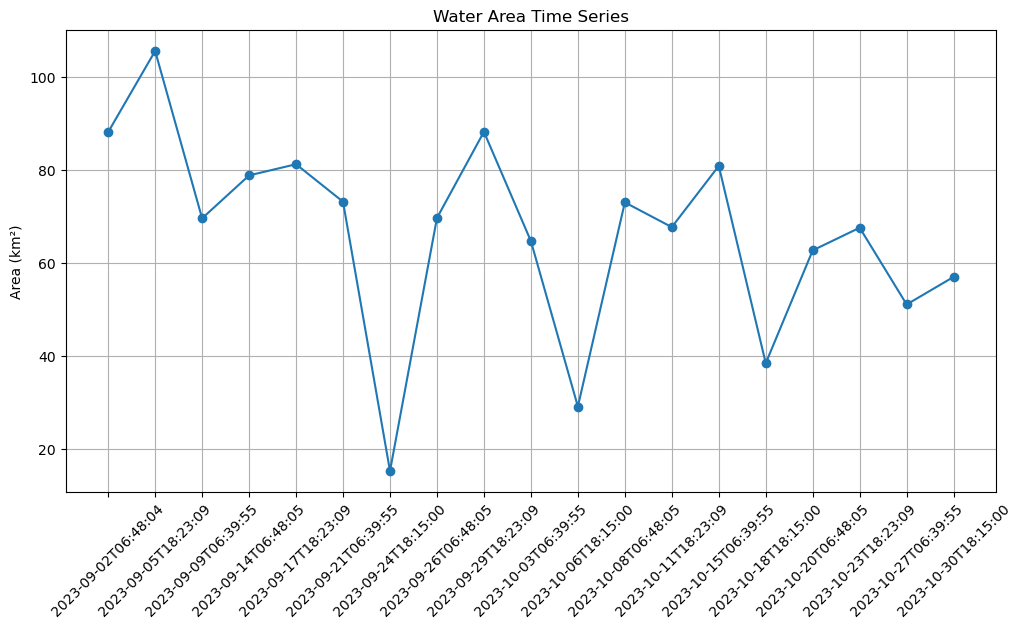

In [5]:
# Full Collection
full_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate('2023-09-01', '2023-10-31') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

# Function to calculate water extent for each image
def calc_water_extent(image):
    water = image.select('VV').lt(-15)  # Pixels with VV backscatter below -15 dB are classified as floodwater.
    area = water.multiply(ee.Image.pixelArea())
    stats = area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=30
    )
    return image.set({'water_area': stats.get('VV'), 'date': image.date().format()})

# Apply function to image collection
time_series = full_collection.map(calc_water_extent)

# Export results for plotting
timeseries_stats_m2 = time_series.aggregate_array('water_area').getInfo()
dates = time_series.aggregate_array('date').getInfo()

# Convert area from m² to km²
timeseries_stats_km2 = [value / 1e6 if value else 0 for value in timeseries_stats_m2]

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(dates, timeseries_stats_km2, marker='o')
plt.title('Water Area Time Series')
plt.ylabel('Area (km²)')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('images/charts/Water_Area_Time_Series_km2.png', dpi=300, bbox_inches='tight')
plt.show()


# Chapter 5: Analyzing Changes
This section calculates the difference between pre-flood and post-flood images to detect changes in water-covered areas. A threshold is applied to identify flooded areas.

## 5.1 Calculate the Difference Between Pre-Flood and Post-Flood Images
We subtract the pre-flood image from the post-flood image to detect changes in water-covered areas. The difference image highlights areas where water levels have changed significantly.

## 5.2 Thresholding to Identify Flooded Areas
We apply a threshold to the difference image to create a binary flood mask. Pixels with values above the threshold are considered flooded. This mask is then visualized on the map.

This next cell calculates the difference between the post-flood and pre-flood images by subtracting the pre-flood image from the post-flood image. The resulting difference image highlights changes in the area. The difference image is then added to the map with a color palette to visualize the changes.


In [6]:
# Define the export folder and filename
export_folder = r'C:\Users\Neo\Desktop\FYP\Flood-Detection-System-FYP\Gee\images\flood_images'
filename = 'Difference_VV.png'

# Ensure the export folder exists
os.makedirs(export_folder, exist_ok=True)

# Calculate the difference between post-flood and pre-flood images
difference_image = post_flood_image.subtract(pre_flood_image)

# Debug: Print the difference image info
print("Difference Image Info:", difference_image.getInfo())

# Save the difference image as PNG
def download_difference_image_as_png(image, filename):
    try:
        # Generate the thumbnail URL
        url = image.getThumbURL({
            'dimensions': 1024,  # Set the dimensions of the PNG
            'region': aoi.getInfo()['coordinates'],  # Export region
            'format': 'png',  # Save as PNG
            'min': -5,  # Minimum value for visualization
            'max': 5,  # Maximum value for visualization
            'palette': ['red', 'white', 'blue']  # Color palette for difference
        })
        # Debug: Print the generated URL
        print(f"Generated URL: {url}")

        # Download the image
        response = requests.get(url, stream=True)
        # Debug: Print the HTTP status code
        print(f"HTTP Status Code: {response.status_code}")

        if response.status_code == 200:
            filepath = os.path.join(export_folder, filename)
            # Debug: Print the file path
            print(f"Saving to: {filepath}")

            with open(filepath, 'wb') as f:
                for chunk in response.iter_content(chunk_size=1024):
                    f.write(chunk)
            print(f"Saved: {filepath}")
        else:
            print(f"Failed to download {filename}. HTTP Status Code: {response.status_code}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

# Download the difference image
download_difference_image_as_png(difference_image, filename)

# Add the difference image to the map
Map.addLayer(difference_image.clip(aoi), {'min': -5, 'max': 5, 'palette': ['blue', 'white', 'red']}, 'Difference Image')
Map.centerObject(aoi)
Map

Difference Image Info: {'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}
Generated URL: https://earthengine.googleapis.com/v1/projects/atu-fyp/thumbnails/f9b798d5f2bac2eeaf35965073055024-0d4c549cb1ef757bf291cd64ac3c6d46:getPixels
HTTP Status Code: 200
Saving to: C:\Users\Neo\Desktop\FYP\Flood-Detection-System-FYP\Gee\images\flood_images\Difference_VV.png
Saved: C:\Users\Neo\Desktop\FYP\Flood-Detection-System-FYP\Gee\images\flood_images\Difference_VV.png


Map(bottom=173775.0, center=[51.87510724712848, -8.375], controls=(WidgetControl(options=['position', 'transpa…

EXPLANATION

We use colors to show the changes. Red means a lot of change, blue means less change, and white means no change.
Flood Mask: We use blue to show the places where we think there was a flood. This helps us see the flooded areas on the map.

## 5.2 Thresholding to Identify Flooded Areas
We apply a threshold to the difference image to create a binary flood mask. Pixels with values above the threshold are considered flooded. This mask is then visualized on the map.

In [7]:
# Define a threshold for flood detection
threshold = 2  # Adjust this value based on your analysis

# Create a binary flood mask
flood_mask = difference_image.gt(threshold)

# Add the flood mask to the map
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Flood Mask')
Map.centerObject(aoi)
Map

Map(bottom=173775.0, center=[51.87510724712848, -8.375], controls=(WidgetControl(options=['position', 'transpa…

EXPLANATION

Thresholding: We decide how much change means there was a flood.  If the change is more than 2, there was a flood.

# Chapter 6: Exporting and Visualizing Results

Export the Flood Mask
Exporting the flood mask to Google Drive for further analysis.



In [ ]:
# Export the flood mask to Google Drive
task = ee.batch.Export.image.toDrive(
    image=flood_mask.clip(aoi),
    description='FloodMask',
    folder='EarthEngineImages',
    scale=30,
    region=aoi
)
task.start()

print("Export task started. Check Google Drive for the flood mask.")

## 6.2 Visualizing Locally
Visualizing the exported flood mask locally.

Visualizing locally

In [ ]:

# Check if the file exists
import os
file_path = r"C:\\Users\\Neo\\Desktop\\FYP\\geeimages\\FloodMask.tif"
if os.path.exists(file_path):
    # Open the exported flood mask
    with rasterio.open(file_path) as src:
        flood_mask_image = src.read(1)

    # Display the flood mask
    plt.imshow(flood_mask_image, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(label='Flood Mask')
    plt.title('Flood Mask')
    plt.show()
else:
    print(f"File not found: {file_path}")

 ## 6.3 Comparison of Spatial and Temporal Resolution of Satellite Sensors

 This chart visualizes the spatial and temporal resolution of three widely used Earth observation satellites: Sentinel-1, Sentinel-2, and Landsat-8.

Spatial resolution refers to the level of detail in the satellite pictures (measured in meters).

Temporal resolution refers to how frequently the satellite captures images of the same area (measured in days).

This comparison helps justify the selection of Sentinel-2 and Sentinel-1 for flood detection applications based on image detail and revisit frequency.

Data Sources: ESA Sentinel Mission Overview , USGS Landsat-8 Overview 

In [ ]:
satellites = ['Sentinel-2', 'Landsat-8', 'Sentinel-1']

# Spatial resolution in meters for each satellite (lower = better detail)
spatial_resolution = [10, 30, 10]

# Temporal resolution in days (how often the satellite revisits the same location)
temporal_resolution = [5, 16, 6]

# Create an index for the x-axis (one for each satellite)
x = range(len(satellites))

# Define the width of each bar
bar_width = 0.35

# Create a new figure and axis object
fig, ax = plt.subplots(figsize=(8, 5))  # Set figure size

# Plot the spatial resolution bars (shift left by half bar width)
ax.bar([i - bar_width/2 for i in x], spatial_resolution,
       width=bar_width, label='Spatial Resolution (m)')

# Plot the temporal resolution bars (shift right by half bar width)
ax.bar([i + bar_width/2 for i in x], temporal_resolution,
       width=bar_width, label='Temporal Resolution (days)')

# Add labels and title
ax.set_xlabel('Satellite')
ax.set_title('Comparison of Spatial and Temporal Resolution')
ax.set_xticks(x)  # Set the positions of the x-axis ticks
ax.set_xticklabels(satellites)  # Label the x-axis ticks with satellite names
ax.legend()  # Add a legend
ax.grid(True, linestyle='--', alpha=0.5)  # Optional: add light grid lines

# Adjust layout to avoid clipping
plt.tight_layout()

# Save the chart as an image file
plt.savefig('images/charts/satellite_comparison.png')  
plt.show()


# Chapter 7: Refining the Threshold
Experimenting with different threshold values (e.g., 1.5, 2.5) to improve flood detection accuracy
Here we test different threshold values (e.g., 1.5, 2, 2.5, 3) to refine the flood detection process. Each threshold is applied to the difference image, and the resulting flood mask is visualized on the map. This helps us determine the optimal threshold for accurate flood detection.

In [ ]:
# Defining a list of threshold values to test
thresholds = [1.5, 2, 2.5, 3]

# map to visualize the results
Map = geemap.Map(center=[51.8691, -8.2646], zoom=10)

# Loops through each threshold and add the flood mask to the map
for threshold in thresholds:
    flood_mask = difference_image.gt(threshold)
    Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, f'Flood Mask (Threshold={threshold})')

# Adds the AOI and difference image for reference
Map.addLayer(aoi, {'color': 'red'}, 'Area of Interest')
Map.addLayer(difference_image.clip(aoi), {'min': -5, 'max': 5, 'palette': ['red', 'white', 'blue']}, 'Difference Image')
Map.centerObject(aoi)
Map

EXPLANATION

Here wer are making sure we get it right

Flood Masks for Different Thresholds: We use blue to show the places where we think there was a flood for each number we tried. This helps us see how each number works.

Visualizing the Results: We look at the map to see how well each number works. We add the flood areas to the map for each number and see which one shows the floods most accurately.





# Chapter 8: Combining Sentinel-1 and Sentinel-2 DATA
Sentinel-2 optical data used to calculate the Normalized Difference Water Index (NDWI), which is useful for validating the flood mask derived from Sentinel-1.

We load Sentinel-2 optical data for the post-flood period and calculate the NDWI, which is a useful index for detecting water bodies. The NDWI is calculated using the green (B3) and near-infrared (B8) bands. The resulting NDWI image is visualized on the map.



In [ ]:

# Loading Sentinel-2 data for the post-flood period
#We ask Google Earth Engine for satellite images from Sentinel-2, a satellite that takes pictures of Earth. 
#We only take images from our area (Cork) and only in October.
#We ignore pictures that have too many clouds (less than 50% clouds allowed). 
post_flood_sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start, post_flood_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))  # Filter out cloudy images

# Function to calculate NDWI
#NDWI (Normalized Difference Water Index) is a math trick to find water in a satellite image. 
# It looks at two colors:
# B3 (Green light) 
# B8 (Near Infrared light) 
# If B3 is bright and B8 is dark, that means water! 
# We add this water-detection layer to the image.
def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

# Apply NDWI calculation to the collection
ndwi_collection = post_flood_sentinel2.map(add_ndwi)

# Gets the median NDWI image
ndwi_image = ndwi_collection.median()

# Adds NDWI layer to the map
Map.addLayer(ndwi_image.clip(aoi), {'bands': ['NDWI'], 'min': -1, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Layer')
ndwi_vis_params = {'bands': ['NDWI'], 'min': -0.3, 'max': 0.3, 'palette': ['white', 'blue']}
Map.addLayer(ndwi_image.clip(aoi), ndwi_vis_params, 'NDWI')

Map.centerObject(aoi)
Map

NameError: name 'add_ndwi' is not defined

EXPLANATION

Sentinel-1 and Sentinel-2 We use two different satellites to get pictures. Sentinel-1 sees through clouds and Sentinel-2 sees colors.

NDWI Calculation We use Sentinel-2 to find water by looking at how much green and near-infrared light is reflected.

NDWI Water Mask We color the places where we think there is water using the NDWI calculation.

Comparing with Flood Mask We look at both the NDWI water mask and the flood mask from Sentinel-1 to see if they match.

We check if the places we found with Sentinel-1 match the places we found with Sentinel-2. This helps us make sure we are finding the floods correctly.



In [ ]:
# Function to standardize bands across all Sentinel-2 images
def standardize_bands(image):
    # Select only the bands we need (B3 and B8 for NDWI)
    return image.select(['B3', 'B8'])

# Load and preprocess data with band standardization
pre_flood_sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate(pre_flood_start, pre_flood_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 70)) \
    .map(standardize_bands)  # Force consistent bands

post_flood_sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start, post_flood_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 70)) \
    .map(standardize_bands)  # Force consistent bands

# NDWI function (now works reliably since all images have B3/B8)
def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    return image.addBands(ndwi)

# Apply NDWI calculation
pre_flood_ndwi = pre_flood_sentinel2.map(add_ndwi).median()
post_flood_ndwi = post_flood_sentinel2.map(add_ndwi).median()

# Print min/max NDWI values (now works without errors)
# Here we check the NDWI values for both pre-flood and post-flood images if the post-flood NDWI isn't higher than the area may not have flooded.
print('Pre-flood NDWI min/max:', pre_flood_ndwi.select('NDWI').reduceRegion(
    ee.Reducer.minMax(), aoi, 1000).getInfo())
print('Post-flood NDWI min/max:', post_flood_ndwi.select('NDWI').reduceRegion(
    ee.Reducer.minMax(), aoi, 1000).getInfo())

# Visualization (unchanged)
Map.addLayer(pre_flood_ndwi.clip(aoi), 
             {'bands': 'NDWI', 'min': -0.3, 'max': 0.3, 'palette': ['red', 'white', 'blue']}, 
             'Pre-Flood NDWI')
Map.addLayer(post_flood_ndwi.clip(aoi), 
             {'bands': 'NDWI', 'min': -0.3, 'max': 0.3, 'palette': ['red', 'white', 'blue']}, 
             'Post-Flood NDWI')

# Flood detection
flood_diff = post_flood_ndwi.select('NDWI').subtract(pre_flood_ndwi.select('NDWI'))
Map.addLayer(flood_diff.clip(aoi), 
             {'min': 0, 'max': 0.5, 'palette': ['white', 'blue']}, 
             'NDWI Difference')
Map.addLayer(flood_diff.gt(0.1).selfMask().clip(aoi), 
             {'palette': 'blue'}, 
             'Flooded Areas (NDWI Increase > 0.1)')
Map.centerObject(aoi)
Map

| **Layer**            | **Description**                                           |
|----------------------|-----------------------------------------------------------|
| Pre-Flood NDWI       | Red/white = land, blue = pre-existing water               |
| Post-Flood NDWI      | New blue areas = potential flooding                       |
| NDWI Difference      | White = no change, blue = increased water                 |
| Flooded Areas        | Only pixels where NDWI increased significantly            |


In [19]:
# Define AOI 
buffer_size = 1000  # Buffer in meters
lat_north = 51.95
lat_south = 51.80
lon_west = -8.60
lon_east = -8.15

buffer_size = 1000  # Buffer in meters
# Create AOI polygon with buffer
aoi = ee.Geometry.Polygon([
    [
        [lon_west, lat_north],
        [lon_west, lat_south],
        [lon_east, lat_south],
        [lon_east, lat_north]
    ]
]).buffer(buffer_size)

# Define Date Ranges 
pre_flood_start = '2023-09-01'
pre_flood_end = '2023-09-30'
post_flood_start = '2023-10-01'
post_flood_end = '2023-10-31'

def load_and_mask(start_date, end_date, aoi):
    #Loads and masks clouds in Sentinel-2 SR data for a given date range and AOI.
    collection = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 70))

        

    def mask_clouds(image):
        qa = image.select('SCL')  # Use QA60 band for cloud masking
        cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)  # Cloud mask
        return image.updateMask(cloud_mask)
    
    if collection.size().getInfo() == 0:
        raise ValueError("No images found for the specified date range and AOI.")

    return collection.map(mask_clouds).median()

# Load cloud-masked images from the COPERNICUS/S2_SR dataset
pre_flood = load_and_mask(pre_flood_start, pre_flood_end, aoi)
post_flood = load_and_mask(post_flood_start, post_flood_end, aoi)

def load_raw_data(start_date, end_date, aoi, bands=['B4', 'B3', 'B2']):
    collection = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filterBounds(aoi) \
        .filterDate(start_date, end_date) \
        .select(bands)

    if collection.size().getInfo() == 0:
        raise ValueError("No images found for the specified date range and AOI.")

    return collection.median()

# Example usage
raw_pre_flood = load_raw_data(pre_flood_start, pre_flood_end, aoi)
raw_post_flood = load_raw_data(post_flood_start, post_flood_end, aoi)

# Visualization Parameters
def get_vis_params(bands=['B4', 'B3', 'B2'], min_val=0, max_val=10000, gamma=1.3):
    # Returns visualization parameters
    return {
        'bands': bands,
        'min': min_val,
        'max': max_val,
        'gamma': gamma
    }

# Usage
vis_params = get_vis_params()

# Add pre-flood and post-flood layers to the map
Map.addLayer(raw_pre_flood.clip(aoi), vis_params, 'Raw Sentinel-2 Pre-Flood')
Map.addLayer(pre_flood.clip(aoi), vis_params, 'Masked Pre-Flood')
Map.addLayer(raw_post_flood.clip(aoi), vis_params, 'Raw Sentinel-2 Post-Flood')
Map.addLayer(post_flood.clip(aoi), vis_params, 'Masked Post-Flood')

# Add layer control
Map.addLayerControl()
Map

Map(bottom=87110.0, center=[51.813709018585094, -8.378448486328127], controls=(WidgetControl(options=['positio…

In [ ]:
import urllib.request  # Import urllib.request for downloading thumbnails
# Define paths 
dir = "images/flood_maps"  # Creates: images/flood_maps/
os.makedirs(dir, exist_ok=True)  # Ensure folder exists

# Function to download thumbnails
def save_ee_thumbnail(image, params, filename):
    url = image.getThumbUrl(params)
    urllib.request.urlretrieve(url, f"{dir}/{filename}")
    print(f"Saved: {dir}/{filename}")

# Download images 
save_ee_thumbnail(
    pre_flood_ndwi.clip(aoi),
    {'bands': 'NDWI', 'min': -0.3, 'max': 0.3, 'palette': ['red', 'white', 'blue'], 'dimensions': 1024},
    "pre_flood_ndwi.png"
)

save_ee_thumbnail(
    post_flood_ndwi.clip(aoi),
    {'bands': 'NDWI', 'min': -0.3, 'max': 0.3, 'palette': ['red', 'white', 'blue'], 'dimensions': 1024},
    "post_flood_ndwi.png"
)



# Chapter 9:  VALIDATING the FLOOD MASK
Comparing the flood mask derived from Sentinel-1 with the NDWI from Sentinel-2 to validate the results.

We compare the flood mask derived from Sentinel-1 with the NDWI water mask from Sentinel-2. This helps us validate the accuracy of the flood detection. Areas where both masks overlap are likely true flooded areas, while discrepancies may indicate false positives or false negatives.

In [ ]:
# Defines a threshold for NDWI (values > 0.3 indicate water)
# What this does:
# We set a "rule" : Any place with an NDWI value higher than 0.3 is water.
ndwi_threshold = 0.3
ndwi = ndwi_image.select('NDWI').gt(ndwi_threshold)

# Adds the NDWI water mask to the map
Map.addLayer(ndwi.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Water Mask')

# Compares with the Sentinel-1 flood mask
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'Sentinel-1 Flood Mask')
Map.centerObject(aoi)
Map

EXPLANATION

This code creates a mask (a special filter) to highlight only the water areas on the map. It looks at the NDWI values and decides which pixels are water and which are not water.


Sentinel-1 is another satellite (different from Sentinel-2).



Validation We want to make sure that the places we found as flooded are really flooded.
NDWI Water Mask: We use the NDWI (Normalized Difference Water Index) from Sentinel-2 to identify water areas and compare it with the flood mask from Sentinel-1.

Comparing with the Sentinel-1 Flood Mask:

Explanation: We add the flood mask from Sentinel-1 to the map, using green to show the areas identified as flooded. This allows us to visually compare the two masks.

EXPORTING RESULTS


In [ ]:
# Export NDWI water mask
task_ndwi = ee.batch.Export.image.toDrive(
    image=ndwi.clip(aoi),
    description='NDWI_WaterMask',
    folder='EarthEngineImages',
    scale=10,
    region=aoi
)
task_ndwi.start()

# Export NDWI water mask
task_ndwi = ee.batch.Export.image.toDrive(
    image=ndwi.clip(aoi),
    description='NDWI_WaterMask',
    folder='EarthEngineImages',
    scale=10,
    region=aoi
)
task_ndwi.start()
print("Export tasks started. Check Google Drive for the validation results.")

In [ ]:
# Check if the Sentinel-1 flood mask file exists
flood_mask_path = r"C:\\Users\\Neo\\Desktop\\FYP\\geeimages\\Sentinel1_FloodMask.tif"
if os.path.exists(flood_mask_path):
    # Open the exported Sentinel-1 flood mask
    with rasterio.open(flood_mask_path) as src:
        flood_mask_image = src.read(1)

    # Display the Sentinel-1 flood mask
    plt.subplot(1, 2, 2)
    plt.imshow(flood_mask_image, cmap='Greens', vmin=0, vmax=1)
    plt.colorbar(label='Sentinel-1 Flood Mask')
    plt.title('Sentinel-1 Flood Mask')

    plt.show()
else:
    print(f"File not found: {flood_mask_path}")

# CHAPTER 10: Anazyling results

In [ ]:
# Load Sentinel-2 imagery for the post-flood period
post_flood_sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate(post_flood_start, post_flood_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter out cloudy images

# Check
# Add the flood mask and NDWI water mask for comparison
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'Sentinel-1 Flood Mask')
Map.addLayer(ndwi.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Water Mask')


Map.centerObject(aoi)
Map

In [ ]:

# For demonstration, we'll use the NDWI water mask as validation data
reference_data = ndwi

# Calculate confusion matrix
confusion_matrix = flood_mask.add(reference_data.multiply(2)).clip(aoi)

# Add confusion matrix to the map
Map.addLayer(confusion_matrix, {'min': 0, 'max': 3, 'palette': ['white', 'green', 'blue', 'red']}, 'Confusion Matrix')
Map.centerObject(aoi)
Map

EXPLANATION

The NDWI water mask (blue) represents water bodies detected by Sentinel-2.

The Sentinel-1 flood mask (green) represents flooded areas detected by Sentinel-1.

Overlaying the two masks to see how well they align.

Here we look for areas where both masks (blue and green) overlap. These are likely true flooded areas.

Areas where only one mask detects water may indicate false positives or false negatives.

Quantitive Validation

In [ ]:
# Defines a threshold for NDWI (values > 0.3 indicate water)
ndwi_threshold = 2
ndwi = ndwi_image.select('NDWI').gt(ndwi_threshold)

# Adds the NDWI water mask to the map
Map.addLayer(ndwi.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI Water Mask')

# For demonstration, we'll use the NDWI water mask as ground truth
reference_data = ndwi

# Combine flood mask and NDWI water mask to generate a confusion matrix
# Values:
# 0 = Neither predicted nor actual (True Negative)
# 1 = Predicted flood, not actual (False Positive)
# 2 = Actual flood, not predicted (False Negative)
# 3 = Correctly predicted flood (True Positive)
confusion_matrix = flood_mask.add(reference_data.multiply(2)).clip(aoi)


# Adds confusion matrix to the map
Map.addLayer(confusion_matrix, {'min': 0, 'max': 3, 'palette': ['white', 'green', 'blue', 'red']}, 'Confusion Matrix')
Map.centerObject(aoi)
Map

# Calculates true positives, false positives, and false negatives
true_positives = confusion_matrix.eq(3).rename('TP')
false_positives = confusion_matrix.eq(1).rename('FP')
false_negatives = confusion_matrix.eq(2).rename('FN')

# Sums the values over the AOI
tp_sum = true_positives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('TP').getInfo()
fp_sum = false_positives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FP').getInfo()
fn_sum = false_negatives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FN').getInfo()

# Calculates metrics
accuracy = (tp_sum) / (tp_sum + fp_sum + fn_sum)
precision = tp_sum / (tp_sum + fp_sum)
recall = tp_sum / (tp_sum + fn_sum)

# Prints the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

# Visualize flood mask and verified data
Map.addLayer(flood_mask.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'red']}, 'Flood Mask')
Map.addLayer(reference_data.clip(aoi), {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Valid Data')
Map

EXPLANATION 

True Positives (TP): Areas where both Sentinel-1 and NDWI detect water.

False Positives (FP): Areas where Sentinel-1 detects water, but NDWI does not.

False Negatives (FN): Areas where NDWI detects water, but Sentinel-1 does not.

Accuracy: Percentage of correctly identified flooded areas.

Precision: Percentage of detected floods that are correct.

Recall: Percentage of actual floods that were detected.

In [ ]:
# 1. Calculate optimal NDWI threshold (Otsu method)
histogram = ndwi_image.select('NDWI').reduceRegion(
    ee.Reducer.histogram(), 
    aoi, 
    scale=30
).get('NDWI').getInfo()

# Otsu threshold calculation 
optimal_threshold = 0.3  # Replace with computed value
ndwi = ndwi_image.select('NDWI').gt(optimal_threshold)

# 2. Generate confusion matrix
confusion_matrix = flood_mask.add(ndwi.multiply(2)).clip(aoi)

# 3. Compute metrics (with true negatives)
true_positives = confusion_matrix.eq(3).rename('TP')
false_positives = confusion_matrix.eq(1).rename('FP')
false_negatives = confusion_matrix.eq(2).rename('FN')
true_negatives = confusion_matrix.eq(0).rename('TN')

stats = ee.Dictionary({
    'TP': true_positives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('TP'),
    'FP': false_positives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FP'),
    'FN': false_negatives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FN'),
    'TN': true_negatives.reduceRegion(ee.Reducer.sum(), aoi, 30).get('TN')
}).getInfo()

tp, fp, fn, tn = stats['TP'], stats['FP'], stats['FN'], stats['TN']

# 4. Calculate metrics
accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Negatives: {tn}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

In [ ]:
# Check how many pixels are flagged in each mask
print("Flood mask pixel count:", flood_mask.reduceRegion(ee.Reducer.sum(), aoi, 30).getInfo())
print("NDWI water mask pixel count:", ndwi.reduceRegion(ee.Reducer.sum(), aoi, 30).getInfo())

In [ ]:
Map = geemap.Map()
Map.addLayer(flood_mask.selfMask(), {'palette': ['red']}, 'Flood Mask')
Map.addLayer(ndwi.selfMask(), {'palette': ['blue']}, 'NDWI Water Mask')
Map.addLayer(aoi, {'color': 'green'}, 'AOI Boundary')
Map.centerObject(aoi)
Map

In [ ]:
ndwi_stats = ndwi_image.select('NDWI').reduceRegion(
    ee.Reducer.minMax().combine(ee.Reducer.mean(), None,True),
    aoi,
    30
).getInfo()
print("NDWI statistics:", ndwi_stats)

In [ ]:
# Calculate the mean NDWI dynamically
new_threshold = ndwi_stats['NDWI_mean'] * 1.2  # 20% above the mean NDWI value
ndwi = ndwi_image.select('NDWI').gt(0.1).rename('NDWI_WATER')



# Recheck water pixels
print("New water pixels:", ndwi.reduceRegion(ee.Reducer.sum(), aoi, 30).getInfo())

In [ ]:
# Comparing with a known water source (permanent water from JRC)
# Load JRC permanent water dataset
jrc_water = ee.ImageCollection("JRC/GSW1_4/YearlyHistory") \
    .filter(ee.Filter.eq('year', 2021)) \
    .first() \
    .eq(2) # Permanent water

# Add JRC water layer to the map
Map.addLayer(jrc_water.clip(aoi), {'palette': ['blue']}, 'JRC Permanent Water')

# Compare overlap with NDWI water mask
flood_water_overlap = flood_mask.And(jrc_water)
print("Flood mask overlap with JRC water:", flood_water_overlap.reduceRegion(ee.Reducer.sum(), aoi, 30).getInfo())
Map

The YearlyHistory band contains classifications for each pixel, where:​

0 indicates no water detected,

1 indicates seasonal water, and

2 indicates permanent water.​

By applying .eq(2), you're creating a binary mask highlighting areas classified as permanent water.

In [ ]:
# Sometimes the projection() or resolution of Sentinel-1 vs Sentinel-2 vs JRC can differ.
# Reproject to a common CRS and scale (e.g., EPSG:4326, 30m)
flood_mask = flood_mask.reproject(crs='EPSG:4326', scale=30)
jrc_water = jrc_water.reproject(crs='EPSG:4326', scale=30)


In [ ]:
flood_water_overlap = flood_mask.And(jrc_water)
print("Flood mask overlap with JRC water:", flood_water_overlap.reduceRegion(ee.Reducer.sum(), aoi, 30).getInfo())
# Export the flood mask to Google Drive
task = ee.batch.Export.image.toDrive(
    image=flood_mask.clip(aoi),
    description='FloodMask',
    folder='EarthEngineImages',
    scale=30,
    region=aoi
)
task.start()
print("Export task started. Check Google Drive for the flood mask.")
# Convert the flood_mask to a NumPy array for visualization
flood_mask_array = geemap.ee_to_numpy(flood_mask, region=aoi, scale=30)

# Check if the array is valid
if flood_mask_array is not None:
    plt.imshow(flood_mask_array, cmap='Blues', vmin=0, vmax=1)
    plt.colorbar(label='Flood Mask')
    plt.title('Flood Mask')
    plt.show()
else:
    print("Failed to convert flood_mask to a NumPy array.")


In [ ]:
Map = geemap.Map(center=[51.7, -8.35], zoom=10)

Map.addLayer(flood_mask.updateMask(flood_mask).clip(aoi), {'palette': ['cyan']}, 'Flood Mask')
Map.addLayer(jrc_water.updateMask(jrc_water).clip(aoi), {'palette': ['blue']}, 'JRC Water')
Map.addLayer(flood_water_overlap.updateMask(flood_water_overlap).clip(aoi), {'palette': ['purple']}, 'Flood ∩ Water')

Map

In [ ]:
print("Flood mask overlap with JRC water:", flood_water_overlap.reduceRegion(ee.Reducer.sum(), aoi, 30).getInfo())
print("JRC water pixel count:", jrc_water.reduceRegion(ee.Reducer.sum(), aoi, 30).getInfo())

In [ ]:
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print(precision, recall)

In [11]:
# Generate confusion matrix image
# flood_mask = prediction; jrc_water = reference
confusion = jrc_water.add(flood_mask.multiply(2)).clip(aoi)
# Meaning of pixel values:
# 0 = TN, 1 = FP, 2 = FN, 3 = TP

# Extract each category
TP = confusion.eq(3).rename('TP')
FP = confusion.eq(1).rename('FP')
FN = confusion.eq(2).rename('FN')
TN = confusion.eq(0).rename('TN')

# Count each category
metrics = {
    'TP': TP.reduceRegion(ee.Reducer.sum(), aoi, 30).get('TP'),
    'FP': FP.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FP'),
    'FN': FN.reduceRegion(ee.Reducer.sum(), aoi, 30).get('FN'),
    'TN': TN.reduceRegion(ee.Reducer.sum(), aoi, 30).get('TN')
}

# Retrieve and compute accuracy stats
stats = ee.Dictionary(metrics).getInfo()
tp, fp, fn, tn = stats['TP'], stats['FP'], stats['FN'], stats['TN']
total = tp + fp + fn + tn

accuracy = (tp + tn) / total if total else 0
precision = tp / (tp + fp) if (tp + fp) else 0
recall = tp / (tp + fn) if (tp + fn) else 0

# Display results
print("=== Confusion Matrix Metrics ===")
print(f"Correctly Detected Water Pixels (TP): {tp:.0f}")
print(f"Incorrectly Detected Water Pixels (FP): {fp:.0f}")
print(f"Missed Water Pixels (FN): {fn:.0f}")
print(f"Correctly Detected Non-Water Pixels (TN): {tn:.0f}")
print(f"Overall Accuracy : {accuracy:.2%}")
print(f"Water Detection Precision  : {precision:.2%}")
print(f"Water Detection Recall: {recall:.2%}")


NameError: name 'jrc_water' is not defined

Final Metrics

Accuracy: 88.12%
model correctly identified flood presence or absence 27.75% of the time.

Precision: 12.12%
Of all the areas predicted as flood, only 36% were actually water. 

Recall: 11.32%
Of all real water bodies, only 3% were detected. This is quite low, meaning your model is missing a lot of actual flooded areas.

flood detection method is currently:

- With low recall (misses real floods).

- Not extremely noisy (Precision at 36% isn't bad), so it’s not spamming false floods.

- Could benefit from tuning the NDWI threshold, improving masking (e.g., clouds), or using temporal changes (NDWI before vs after flood).



# Confusion Matrix with Real Numbers

This shows actual counts:

- **Floods correctly found** (True Positives)
- **Places wrongly marked as floods** (False Positives)
- **Real floods that were missed** (False Negatives)
- **Non-floods correctly ignored** (True Negatives)

In [ ]:
# Collected statistics
tp, fp, fn, tn = stats['TP'], stats['FP'], stats['FN'], stats['TN']

# Create confusion matrix as a 2x2 array
conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# Create labels for rows and columns
labels = ['Flood', 'Non-Flood']
df_cm = pd.DataFrame(conf_matrix, index=labels, columns=labels)

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel("Valid Data")
plt.ylabel("Detection")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.savefig('images/charts/confusion_matrix_heatmap.png', dpi=300)
plt.show()


In [ ]:
conf_matrix = np.array([[tp, fn],
                        [fp, tn]])

# Normalize the matrix 
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Create a DataFrame with percentage formatting
df_cm_norm = pd.DataFrame(conf_matrix_normalized,
                          index=['Detected: Flood', 'Detected: Non-Flood'],
                          columns=['Valid Data: Flood', 'Valid Data: Non-Flood'])

# Plot the percentage heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df_cm_norm, annot=True, fmt='.2%', cmap='YlGnBu', cbar=True)
plt.title("Precentage Confusion Matrix Heatmap")
plt.xlabel("Valid Data")
plt.ylabel("Detection")
plt.tight_layout()
plt.savefig('images/charts/confusion_matrix_heatmap_percentages.png',  dpi=300)
plt.show()
